In [1]:
%matplotlib inline

In [56]:
import os
import re
import pandas as po
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import fancyimpute
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [3]:
path = os.getcwd()
path = re.sub('notebooks', '', path)

In [4]:
input_raw = po.read_csv(path+'data/raw/train.csv', header=0)

In [5]:
input_raw.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
input_raw.shape

(891, 12)

In [7]:
input_raw['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

# Simulating Random Data

test = np.random.normal(loc=0, scale=1, size=10000)

test = test.reshape(1000,10)

test = po.DataFrame(test, columns=['var_'+str(i) for i in range(10)])

for col in test.columns:

    test[col] = (test[col]*np.random.randint(low=10, high=100, size=1))

test.describe()

test.mean()

test.cov()

test1 = po.DataFrame(np.random.multivariate_normal(test.mean(), test.cov(), size=10000), columns=test.columns)

for col in test.columns:

    test1[col] = test1[col].clip(test[col].min(), test[col].max())

test1 = test1.fillna(test1.mean())

test1.info()

sns.distplot(test['var_0'])

sns.distplot(test1['var_0'])

In [8]:
input_raw = input_raw.set_index('PassengerId')

In [9]:
input_raw.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked  
PassengerId                                                          
1                1      0         A/5 21171   7.2500   NaN        S  
2                1      0          PC 17599  71.2833   C85        C  
3                0      0  STON/O2. 3101282   7.9250   NaN        S  
4                1      0            113803  53.1000  C123        S  
5                0      0            373450   8.0500   NaN        S

In [10]:
input_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [11]:
print(input_raw.groupby('Survived')['Age'].mean())
print(input_raw.groupby('Survived')['Age'].std())

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64
Survived
0    14.172110
1    14.950952
Name: Age, dtype: float64


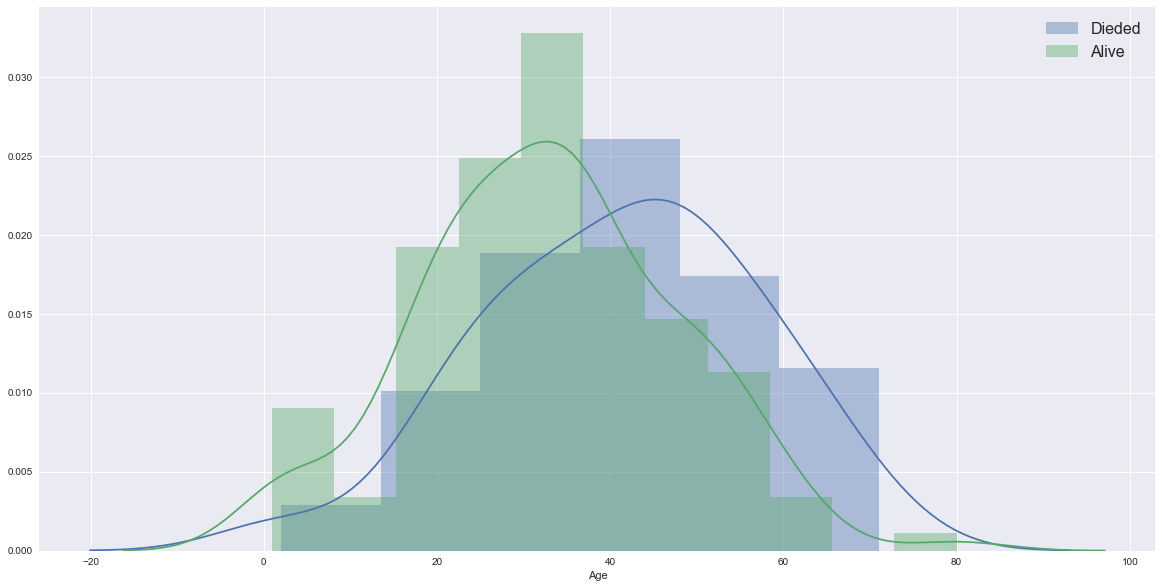

In [12]:
fig=plt.figure(figsize=[20,10])
input_raw1 = input_raw.copy()
#input_raw1 = input_raw1.fillna(input_raw1.mean())
input_raw1 = input_raw1.dropna(axis=0)
sns.distplot(input_raw1.loc[input_raw1['Survived']==0, 'Age'], label='Dieded')
sns.distplot(input_raw1.loc[input_raw1['Survived']==1, 'Age'], label='Alive')
plt.legend(fontsize=16)

In [13]:
input_raw2 = input_raw.copy()
input_raw2['Age'] = po.to_numeric(input_raw2['Age'], errors='coerce')
no_na = input_raw.dropna(axis=0).reset_index()
for i in input_raw2.index:
    print(input_raw2.loc[i, 'Age'])
    #if input_raw2.loc[i, 'Age'] == input_raw2.loc[6, 'Age']:
    if np.isnan(input_raw2.loc[i, 'Age']):
        using = no_na.ix[np.random.randint(low=0, high=no_na.index.max(), size=1),'Age']
        print("Using :%f" % using)
        input_raw2['Age'].loc[i,] = using
    #else:
        #print(input_raw2.loc[i, 'Age'])

22.0
38.0
26.0
35.0
35.0
nan
Using :31.000000
54.0
2.0
27.0
14.0

C:\Continuum\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
C:\Continuum\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value



4.0
58.0
20.0
39.0
14.0
55.0
2.0
nan
Using :24.000000
31.0
nan
Using :40.000000
35.0
34.0
15.0
28.0
8.0
38.0
nan
Using :17.000000
19.0
nan
Using :27.000000
nan
Using :29.000000
40.0
nan
Using :54.000000
nan
Using :24.000000
66.0
28.0
42.0
nan
Using :27.000000
21.0
18.0
14.0
40.0
27.0
nan
Using :52.000000
3.0
19.0
nan
Using :4.000000
nan
Using :33.000000
nan
Using :40.000000
nan
Using :18.000000
18.0
7.0
21.0
49.0
29.0
65.0
nan
Using :22.000000
21.0
28.5
5.0
11.0
22.0
38.0
45.0
4.0
nan
Using :44.000000
nan
Using :30.000000
29.0
19.0
17.0
26.0
32.0
16.0
21.0
26.0
32.0
25.0
nan
Using :36.000000
nan
Using :27.000000
0.83
30.0
22.0
29.0
nan
Using :36.500000
28.0
17.0
33.0
16.0
nan
Using :30.000000
23.0
24.0
29.0
20.0
46.0
26.0
59.0
nan
Using :52.000000
71.0
23.0
34.0
34.0
28.0
nan
Using :38.000000
21.0
33.0
37.0
28.0
21.0
nan
Using :44.000000
38.0
nan
Using :61.000000
47.0
14.5
22.0
20.0
17.0
21.0
70.5
29.0
24.0
2.0
21.0
nan
Using :30.000000
32.5
32.5
54.0
12.0
nan
Using :24.000000
24.0
na

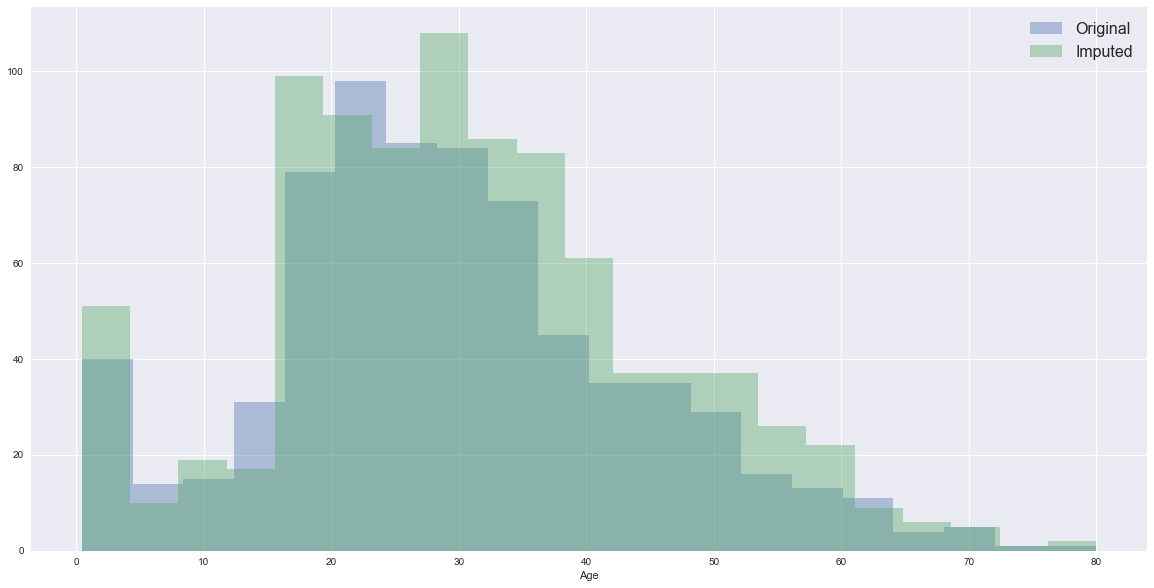

In [14]:
plt.figure(figsize=[20,10])
sns.distplot(input_raw['Age'].dropna(axis=0), label='Original', kde=0)
sns.distplot(input_raw2['Age'], label='Imputed', kde=0)
plt.legend(fontsize=16)

MICE = Multiple Imputation by Chained Equations

In [15]:
input_raw3 = input_raw.copy()
for col in input_raw3.columns:
    if input_raw3[col].dtype=='object':
        del input_raw3[col]
input_raw4 = po.concat([input_raw3.drop('Pclass', axis=1), po.get_dummies(input_raw3['Pclass'], prefix="Pclass_")], axis=0)

In [16]:
input_raw4.dtypes

Age          float64
Fare         float64
Parch        float64
Pclass__1    float64
Pclass__2    float64
Pclass__3    float64
SibSp        float64
Survived     float64
dtype: object

In [17]:
input_raw4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 1 to 891
Data columns (total 8 columns):
Age          714 non-null float64
Fare         891 non-null float64
Parch        891 non-null float64
Pclass__1    891 non-null float64
Pclass__2    891 non-null float64
Pclass__3    891 non-null float64
SibSp        891 non-null float64
Survived     891 non-null float64
dtypes: float64(8)
memory usage: 125.3 KB


In [18]:
exog = input_raw3['Survived']
endog = input_raw3.drop('Survived', axis=1) 

In [19]:
endog1 = po.DataFrame(fancyimpute.MICE().complete(endog.values), columns=endog.columns)

[MICE] Completing matrix with shape (891, 5)
[MICE] Starting imputation round 1/110, elapsed time 0.000
[MICE] Starting imputation round 2/110, elapsed time 0.000
[MICE] Starting imputation round 3/110, elapsed time 0.000
[MICE] Starting imputation round 4/110, elapsed time 0.004
[MICE] Starting imputation round 5/110, elapsed time 0.004
[MICE] Starting imputation round 6/110, elapsed time 0.004
[MICE] Starting imputation round 7/110, elapsed time 0.004
[MICE] Starting imputation round 8/110, elapsed time 0.004
[MICE] Starting imputation round 9/110, elapsed time 0.008
[MICE] Starting imputation round 10/110, elapsed time 0.008
[MICE] Starting imputation round 11/110, elapsed time 0.008
[MICE] Starting imputation round 12/110, elapsed time 0.008
[MICE] Starting imputation round 13/110, elapsed time 0.008
[MICE] Starting imputation round 14/110, elapsed time 0.012
[MICE] Starting imputation round 15/110, elapsed time 0.012
[MICE] Starting imputation round 16/110, elapsed time 0.012
[MIC

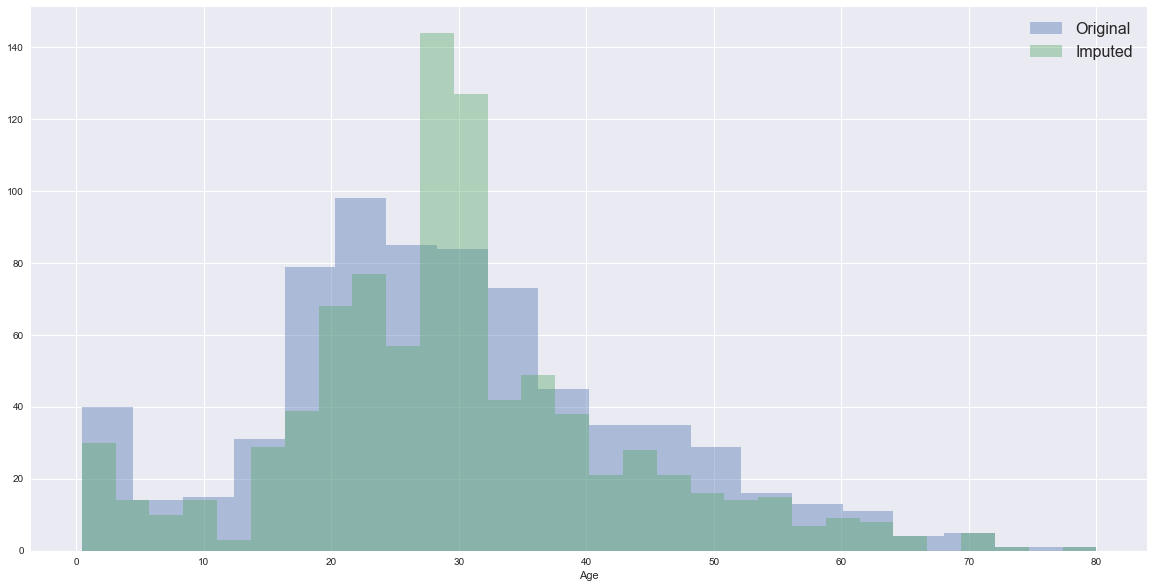

In [20]:
plt.figure(figsize=[20,10])
sns.distplot(input_raw['Age'].dropna(axis=0), label='Original', kde=0)
sns.distplot(endog1['Age'], label='Imputed', kde=0)
plt.legend(fontsize=16)

In [21]:
exog1 = exog.reset_index()
endog2 = endog1.reset_index()
input_raw5 = po.concat([exog1, endog2], axis=1)
input_raw5['is_train'] = np.random.random(size=input_raw5.shape[0]) < 0.8

In [22]:
train = input_raw5[input_raw5['is_train']==True]
test = input_raw5[input_raw5['is_train']==False]

In [23]:
print(train.shape)
print(test.shape)

(733, 9)
(158, 9)


In [57]:
#leia = GaussianNB()
leia = RandomForestClassifier(max_depth=2, random_state=0)
y_pred = leia.fit(train.drop('Survived', axis=1), train['Survived']).predict_proba(test.drop('Survived', axis=1))[:,1]
y_pred1 = leia.fit(train.drop('Survived', axis=1), train['Survived']).predict(test.drop('Survived', axis=1))

In [58]:
print("Number of mislabeled points out of a total %d points : %d" % (test.drop('Survived', axis=1).shape[0],(test['Survived'] != y_pred1).sum()))

Number of mislabeled points out of a total 158 points : 53


## Confusion Matrix
                    Actual 0        Actual 1
    Predicted 0:    True Negative  | False Negative
______________________________
    Predicted 1:    False Positive | True Positive

In [59]:
confusion_matrix(test['Survived'], y_pred1)

array([[97,  1],
       [52,  8]])

## ROC Curve

In [60]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()
#for i in range(2):
fpr, tpr, _ = roc_curve(test['Survived'], y_pred)
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(test['Survived'], y_pred1)
roc_auc1 = auc(fpr1, tpr1)

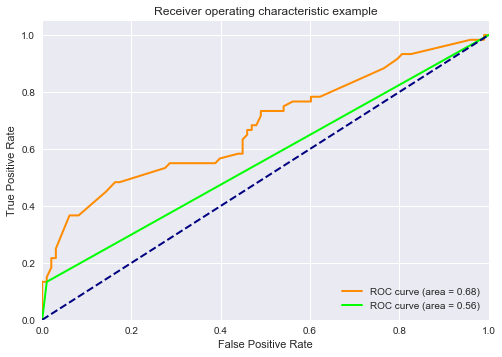

In [61]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr1, tpr1, color='lime',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()